In [1]:
import cv2
import numpy as np
import insightface
# from insightface.app import FaceAnalysis
# from insightface.data import get_image as ins_get_image
import pickle
# from tqdm import tqdm
# import onnx
# import onnxruntime
# import os
from collections import OrderedDict
import time
from functools import reduce
import matplotlib.pyplot as plt
from dbface_detect_align_module import dbface_detect as dbface
# import torch
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

SystemError: <built-in function __import__> returned a result with an error set

In [2]:
def performance(f):
    def fn(*args, **kw):
        t1 = time.time()
        r = f(*args, **kw)
        t2 = time.time()
        print('call {} in {}s'.format(f.__name__,(t2-t1)))
        return r
    return fn


def compute_cos_sim(emb1, emb2):
    sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    return sim


@performance
def topk_sim(img_emb, mean_emb_dict, k):
    sims = []
    for celeb in mean_emb_dict:
        sims.append((celeb, compute_cos_sim(img_emb, mean_emb_dict[celeb])))
    
    sorted_sims = sorted(sims, key=lambda x:x[1], reverse=True)
    return sorted_sims[:k]


def softmax(res):
    def f1(x):
        return np.exp(x[1])

    def f2(x, y):
        return x + y

    total = reduce(f2, map(f1, res))
    sims = []

    for item in res:
        sims.append((item[0], f1(item)/total))

    return sims

def knn_sim(res):
    total = 0
    for item in res:
        total += item[1]
    for i in range(len(res)):
        res[i] = (res[i][0], res[i][1]/total)

In [3]:
# with open('./embeddings/w600k_r50.onnx_aligned_mean_emb_dict.pkl', 'rb') as f:
#     mean_emb_dict = pickle.load(f)
with open('./embeddings/w600k_r50.onnx_aligned_img_dict.pkl', 'rb') as f:
    image_dict = pickle.load(f)
model = 'w600k_r50.onnx'

In [4]:
handler = insightface.model_zoo.get_model(model,
                                          providers=['CPUExecutionProvider'])
handler.prepare(ctx_id=0)
# lffdface_detect = lffdface(version=1)
dbface_detect = dbface(net_type='dbface',device='cpu', align=True)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


In [61]:
test_img = './test/geo/geo6.jpg'
image = cv2.imread(test_img)

In [6]:
with open('./embeddings/w600k_r50.onnx_aligned_emb_dict.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)

X = normalize(X)
knn = KNN(n_neighbors=100,algorithm='brute')
knn.fit(X,y)

KNeighborsClassifier(algorithm='brute', n_neighbors=100)

In [62]:
st = time.time()
_, aligned_face = dbface_detect.detect(image)

if len(aligned_face) == 0:
    print('face not detected')
else:
    aligned = aligned_face[0]

face_embedding = handler.get(aligned)

face_embedding = normalize(face_embedding.reshape((1,face_embedding.shape[0])))
preds = knn.predict_proba(face_embedding)

predictions = []
count = 0
for pred in preds[0]:
    predictions.append((le.classes_[count],pred))
    count += 1
sorted_preds = sorted(predictions, key=lambda x:x[1], reverse=True)

sims = sorted_preds[:3]
knn_sim(sims)
et = time.time()
print(sims)
print('time used: {}s'.format(et-st))

[('pins_Morgan Freeman', 0.5128205128205129), ('pins_Madelaine Petsch', 0.28205128205128205), ('pins_Katherine Langford', 0.20512820512820512)]
time used: 0.16390442848205566s


(-0.5, 250.5, 265.5, -0.5)

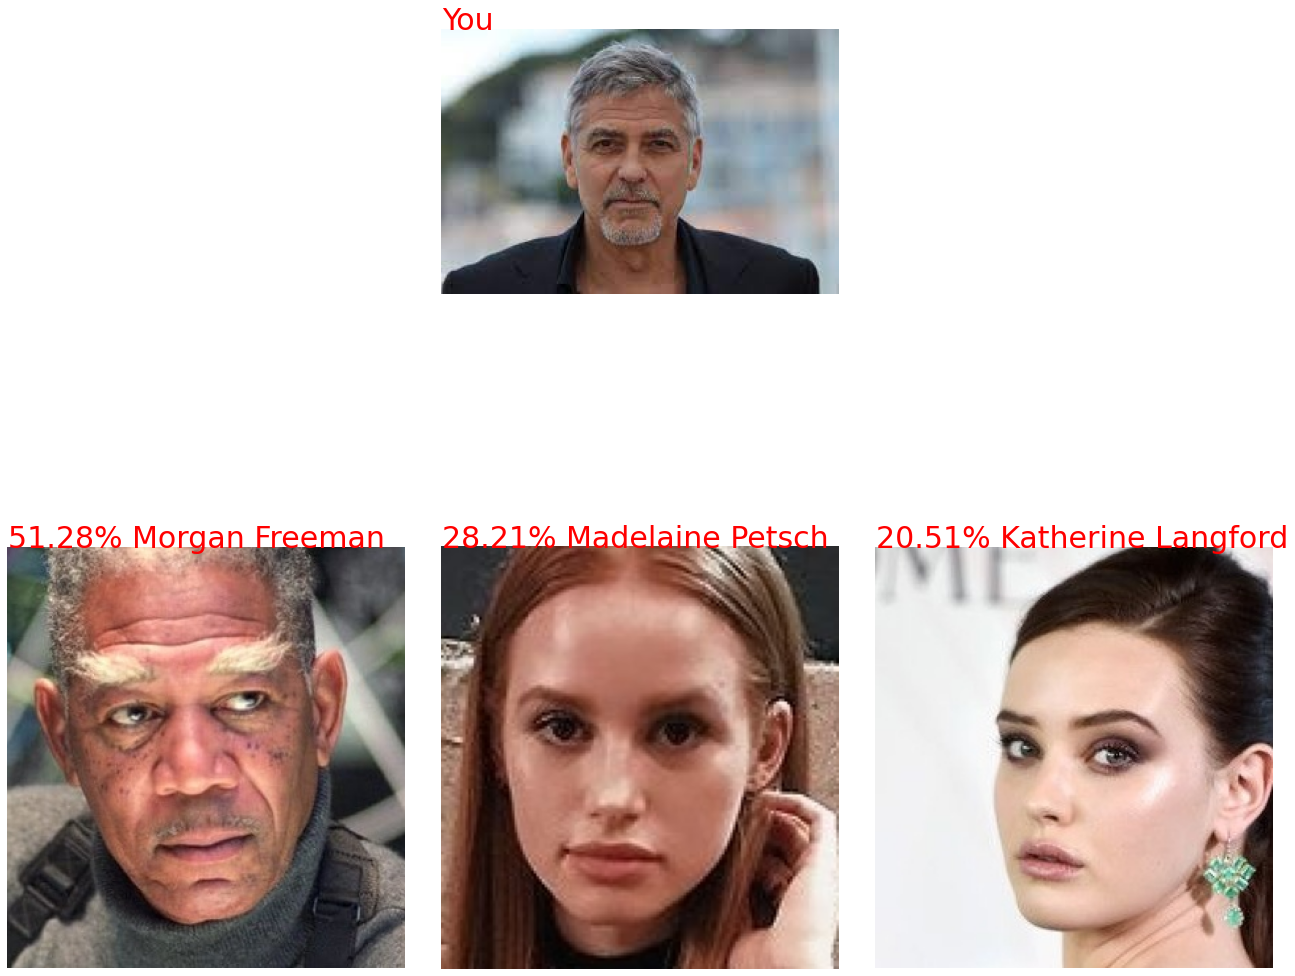

In [63]:
img_paths = OrderedDict()
pins = './research_data/105_classes_pins_dataset/'

for celeb in sims:
    max_sim = -1
    max_img = None

    for img, emb in image_dict[celeb[0]]:
        emb = normalize(emb.reshape((1,-1)))
        sim = compute_cos_sim(emb.reshape((-1,)), face_embedding.reshape((-1,)))
        if sim > max_sim:
            max_sim = sim
            max_img = img

    img_paths[celeb[0]] = pins + celeb[0] + '/' + max_img

imgs = list(img_paths.values())
celebs = list(img_paths.keys())

plt.rcParams['figure.figsize'] = (18, 18)

plt.subplot(232)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
plt.xlabel('You are: ')
plt.text(0, 0, 'You', size=30, c='red')
plt.tight_layout(h_pad=0, w_pad=0)
plt.axis('off')

plt.subplot(234)
img1 = cv2.imread(imgs[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
plt.imshow(img1)
# plt.xlabel('{}% like {}'.format(round(sims[0][1]*100), sims[0][0].split('_')[1]))
plt.tight_layout(h_pad=0, w_pad=1)
plt.text(0, 0, '{}% {}'.format(round(sims[0][1]*100, 2), sims[0][0].split('_')[1]), size=30, c='red')
plt.axis('off')

plt.subplot(235)
img2 = cv2.imread(imgs[1])
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img2)
# plt.xlabel('{}% like {}'.format(round(sims[1][1]*100), sims[1][0].split('_')[1]))
# plt.tight_layout(h_pad=0, w_pad=1)
plt.text(0, 0, '{}% {}'.format(round(sims[1][1]*100, 2), sims[1][0].split('_')[1]), size=30, c='red')
plt.axis('off')

plt.subplot(236)
img3 = cv2.imread(imgs[2])
img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
plt.imshow(img3)
# plt.xlabel('{}% like {}'.format(round(sims[2][1]*100), sims[2][0].split('_')[1]))
plt.tight_layout(h_pad=0, w_pad=1)
plt.text(0, 0, '{}% {}'.format(round(sims[2][1]*100, 2), sims[2][0].split('_')[1]), size=30, c='red')
plt.axis('off')

In [11]:
import sklearn
sklearn.__version__

'1.0.2'